In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np

In [3]:
import scipy.io as sio

In [4]:
df = sio.loadmat('snelson1d.mat')

In [5]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [6]:
M = 20

In [186]:
N_star = 25

In [162]:
X_u_noisy = np.linspace(0,6, M)[:, None]

In [175]:
stan_code_var = """
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real jitter = 1e-6;
//     real rho = 0.9;
//     real alpha = 0.85;
//     real sigma = 0.12;
}

parameters {
    real<lower=1e-6> sigma;
     real <lower=1e-6> alpha;
     real<lower=1e-6> rho;
    
    vector[M] eta;
    vector[M] u;
    
}

transformed parameters{
   // matrix[M, M] R;
}
model {
    vector[N] mu;
    matrix[N, N] f_cov;
    matrix[N, N] S;
    matrix[M, N] A;
    matrix [N,N] Qff;
    matrix [N,N] L_fitc;
    matrix[N, N] K_tilde;
    matrix[N, N] K_tilde_inv;
    matrix[M, M] R;
    
    matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
    matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    vector[M] Kuu_inv_u;

        
         for (m in 1:M)
             Kuu[m, m] = Kuu[m, m] + jitter;
        
        // RRT = Kuu
    R = cholesky_decompose(Kuu);
        
    {
        

                  
        //A = R^{-1}Kuf   or A = R\Kuf
        A = mdivide_left_tri_low(R, Kfu');
        
        // mu = A'v
        //  v = N(0, I)
        mu = A'*eta;
        
        // Qff = A'A
        Qff = A'*A;
        S = K - Qff;
        
        for (i in 1:N){
            for(j in 1:N){
                K_tilde[i,j] = 0.0;
                K_tilde_inv[i,j] = 0.0;
            }
            K_tilde[i,i] = S[i,i];
            K_tilde_inv[i,i] = 1./ S[i,i];
        }
        
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);

// strongly informative priors, but with these the covariance matrix will be more well behaved in my experience.
// The mean of the Gaussian priors is close to the optimised MAP value of the hyperparameters.

    rho ~ normal(0.90, 0.25);
    alpha ~ normal(0.85, 0.25);
    eta ~ normal(0, 1);

    sigma ~ normal(0, 0.60);
    
    
    // exp(L1) = log(N(y_i| mu_i, sigma)*exp(-0.5*K_tilde_ii/sigma))
    // Equation 2 of Hensman, et al. Gaussian Processes for Big Data UAI 2013.
    // This is the analytical soln. of expectation of log likelihood under conditional Guassian: P(F|U).
    // K_tilde_ii = diag(Kff - Qff)[i,i]
    
    
    for(i in 1:N){
 //       target += -square((y[i] - mu[i]))/(2*square(sigma));
//        target += normal_lpdf(y[i] | mu[i], sigma);
//        target += (-0.5*K_tilde[i,i]/sigma);
        
        target += normal_lpdf(y[i] | mu[i], sigma);
        target += (-0.5*K_tilde[i,i]/sigma);

    }
    

}


"""

In [239]:
stan_model_var = pystan.StanModel(model_code=stan_code_var)

In [166]:
gp_var_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'xu':X_u_noisy.flatten()}

In [167]:
fit_var= stan_model_var.sampling(data=gp_var_data, iter=400, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [169]:
samples = fit_var.extract()
u = samples['u']
u_mean = np.mean(u, axis=0)
sigma = samples['sigma']
l = samples['rho']
sigvar = samples['alpha']
sigma_mean = np.mean(sigma, axis=0)

In [170]:
print(fit_var)

Inference for Stan model: anon_model_008efae7c702dce5b5f4f88a44813e6d.
2 chains, each with iter=400; warmup=200; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=400.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma     0.28  7.0e-4   0.01   0.26   0.27   0.28   0.29   0.31    400    1.0
alpha     0.94    0.01   0.18   0.61    0.8   0.93   1.04   1.33    256    1.0
rho       0.63  3.1e-3   0.06   0.51   0.59   0.63   0.67   0.75    400    1.0
eta[0]    -0.1  7.7e-3   0.14  -0.37  -0.19  -0.09-9.2e-3   0.16    326    1.0
eta[1]   -0.74    0.02   0.33  -1.46  -0.93  -0.72  -0.53  -0.12    344    1.0
eta[2]   -1.16    0.03   0.49  -2.27  -1.48  -1.11  -0.83  -0.25    345    1.0
eta[3]   -1.15    0.03   0.58  -2.29  -1.56  -1.09  -0.75  -0.08    321    1.0
eta[4]   -1.02    0.03   0.63  -2.25  -1.42  -1.02  -0.61   0.21    400    1.0
eta[5]    0.13    0.04   0.74  -1.32  -0.36   0.16   0.66   1.47    400    1.0
eta[6]    0.97    0.03   

In [177]:
# mu = samples['mu']
print(list(samples.keys()))
# sigma_mean = np.mean(mu, axis=0)

['sigma', 'alpha', 'rho', 'eta', 'u', 'lp__']


In [153]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']

In [134]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.19
median of noise variance: 0.19
mean of lengthscale: 0.597
median of lengthscale: 0.598
mean of signal variance: 0.940
median of signal variance: 0.930


In [135]:
eta = samples['eta']

In [141]:
print(eta.shape)

(400, 20)


In [142]:
eta_mean = np.mean(samples['eta'], axis=0)
eta_median = np.nanmedian(samples['eta'], axis=0)

In [137]:
eta_perc_25 = np.percentile(eta, 2.5, axis=0)
eta_perc_975 = np.percentile(eta, 97.5, axis=0)

In [138]:
eta_mean = np.mean(eta)

#### Plotting posterior distribution of v.

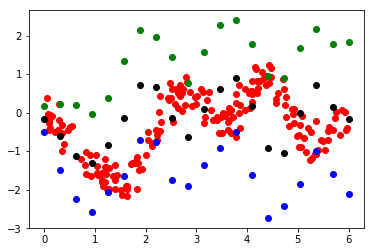

In [147]:
plt.plot(X,Y, 'ro')
plt.plot(X_u_noisy, eta_perc_25, 'bo')
plt.plot(X_u_noisy, eta_perc_975, 'go')
plt.plot(X_u_noisy, eta_mean, 'ko')
# plt.plot(X_u_noisy, eta_mean, 'yo')
# plt.plot(X, f[320,:], 'go')

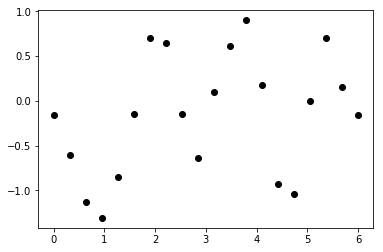

In [146]:
plt.plot(X_u_noisy, eta_mean, 'ko')

In [119]:
u_perc_25 = np.percentile(u, 2.5, axis=0)
u_perc_975 = np.percentile(u, 97.5, axis=0)

In [249]:

class ProcessStanSamples(object):
    
    def _params_samples(samples):
        keys = list(samples.keys())
        return keys
    
    def plot_histograms(samples):
        sigma_samples = samples['sigma']
        rho_samples = samples['rho']
        alpha_samples = samples['alpha']
        if 'f' in self._params_samples(samples):
            f_samples = samples['f']
        
        if 'u' in self._params_samples(samples):
            u_samples = samples['u']
        
        
        f, axs = plt.subplots(2,2, sharey=True)
        axs[0,0].hist(sigma_samples)
        axs[0,0].set_title('Plotting samples for sigma')
        axs[0,0].legend(['Noise variance'])
        axs[0,1].hist(rho_samples)
        axs[0,1].set_title('Plotting samples for lengthscale')
        axs[0,1].legend(['lengthscale'])
        axs[1,0].hist(alpha_samples)
#         axs[1,0].set_title('Plotting samples for signalvariance')
        axs[1,0].legend(['signal var'])
        
    

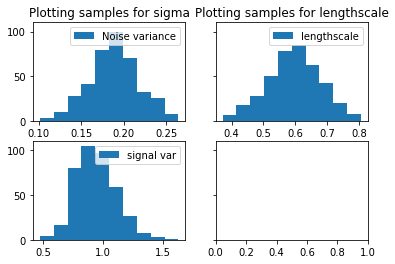

In [251]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [181]:
eta_samples = samples['eta']

In [252]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]
M = 20

In [179]:
print(alpha_samples.shape)

(400,)


In [189]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K
    

In [190]:
Kuu = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_u_noisy)

In [191]:
K_star_u = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_star, Xj=X_u_noisy)

In [210]:
alpha_sub_samples = alpha_samples[::40]
rho_sub_samples = rho_samples[::40]
sigma_sub_samples = sigma_samples[::40]
eta_sub_samples = eta_samples[::40,:]

In [235]:
print(alpha_sub_samples.shape)
N_s = 10

(10,)


####  Utility function to generate predictive distribution:

$p(f^*|y) = \int \int p(f^*|u) q(u, \theta) du d\theta$

We will obtain the above expression using MCMC samples. The stan code above samples from the optimal variational distribution $q(u,\theta)$

In [226]:
# function to generate mean and covariance matrics ..

def generate_preds(alpha, rho, v, Xi, Xj):
    Kuu = kernel_rbf(alpha, rho, Xi=X_u_noisy)
    K_star_u = kernel_rbf(alpha, rho, Xi=X_star, Xj=X_u_noisy)
    K_star_star = kernel_rbf(alpha, rho, Xi=X_star)
    
    R = np.linalg.cholesky(Kuu)
    A = np.linalg.solve(R, np.transpose(K_star_u))
#     print(A.shape)
    A_T = np.transpose(A)
    f_star_mean = np.dot(A_T, v)
    Q_star_star = np.dot(A_T, A)
    
    S = K_star_star - Q_star_star
    return f_star_mean, S



In [236]:
f_sum = np.zeros(25)
S_sum = np.zeros((25,25))
for i in range(10):
    f_star_mean, S = generate_preds(alpha=alpha_sub_samples[i], rho =rho_sub_samples[i], v =eta_sub_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    S_sum = S_sum + S


####   Plot for predictive distribution for Snelson dataset using samples obtained from optimal variational distribution : q(v, $\theta$)

In [237]:
f_fin = f_sum / N_s
S_sum = S_sum / N_s

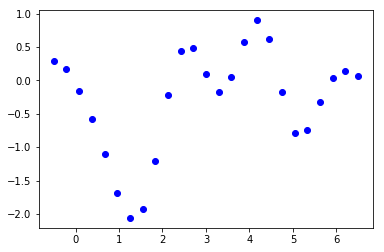

In [238]:
plt.plot(X_star, f_fin, 'bo')

In [231]:
N_full = 400

In [227]:
f_sum = np.zeros(25)
S_sum = np.zeros((25,25))
for i in range(400):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    S_sum = S_sum + S

In [232]:
f_fin = f_sum / N_full
S_sum = S_sum / N_full

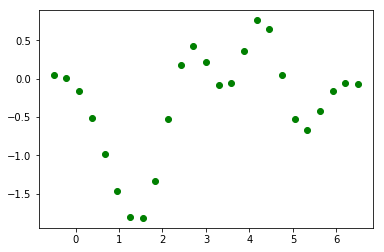

In [233]:
plt.plot(X_star, f_fin, 'go')

In [243]:

a = np.random.multivariate_normal(f_fin, S_sum, 6)

In [244]:
print(a.shape)

(6, 25)


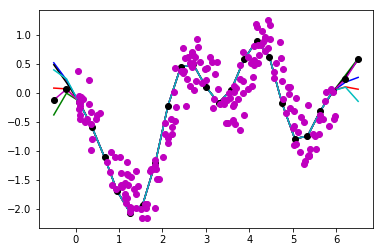

In [253]:
plt.plot(X_star, a[0], 'g-')
plt.plot(X_star, a[1], 'b-')
plt.plot(X_star, a[2], 'r-')
plt.plot(X_star, a[3], 'k-')
plt.plot(X_star, a[4], 'm-')
plt.plot(X_star, a[5], 'c-')
plt.plot(X_star, a[4], 'ko')
plt.plot(X, Y, 'mo')